# Replicability Check
I have checked with another platform.
1. Created a virtual environment: `python -m venv env`
2. Activated the environment: `source env/bin/activate`
3. Installed dependencies: `pip install -r requirements.txt`
4. Ran the notebook using Jupyter: `jupyter notebook week5Lab.ipynb`


# Data Tidying and Cleaning

Data tidying and cleaning are critical steps in data engineering to make datasets readable, complete, and analysis-ready. This notebook demonstrates:

- **Tidying**: Reshaping datasets using `pandas` functions like `melt` and `pivot_table` to ensure each variable is a column, each observation is a row, and each observational unit forms a table.
- **Cleaning**: Handling missing values, removing outliers, and correcting inconsistencies to prepare data for visualization or modeling.
- **Outlier Detection**: Identifying and managing outliers using visualization, Z-Score, and Inter-Quartile Range (IQR) methods.

We use four datasets:
1. **PEW Research**: Income distributions by religion.
2. **Billboard**: Weekly song rankings.
3. **Cars**: Car attributes for cleaning.
4. **Diabetes**: Health metrics for outlier detection.

## PEW Research Dataset

This dataset from PEW Research shows income distributions across religious groups in the US. A tidy dataset satisfies:

1. Each variable forms a column.
2. Each observation forms a row.
3. Each observational unit forms a table.

Our goal is to reshape the dataset so that religion, income range, and count are distinct columns.

Importing libraries:-

In [40]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from rich.console import Console
from rich.table import Table

### Step 1: Load the Dataset

We start by loading the dataset into a pandas DataFrame.

In [41]:

# Load the PEW dataset
df_pew = pd.read_csv('./CSVs/pew-raw.csv')

# Display the first few rows
df_pew.head(5)

,religion,<$10k,$10-20k,$20-30k,$30-40k,$40-50k,$50-75k
0,Agnostic,27,34,60,81,76,137
1,Atheist,12,27,37,52,35,70
2,Buddhist,27,21,30,34,33,58
3,Catholic,418,617,732,670,638,1116
4,Dont know/refused,15,14,15,11,10,35


### Step 2: Observe the Dataset

The dataset has income ranges as column headers, which represent values, not variables. This violates tidy data principles. We need to reshape it so that income ranges become a single column.

In [42]:
# Use iloc to view a subset of the data
df_pew.iloc[:5, :5]

,religion,<$10k,$10-20k,$20-30k,$30-40k
0,Agnostic,27,34,60,81
1,Atheist,12,27,37,52
2,Buddhist,27,21,30,34
3,Catholic,418,617,732,670
4,Dont know/refused,15,14,15,11


### Step 3: Tidy with `melt`

We use `pd.melt` to reshape the dataset, keeping `religion` as the identifier and transforming income range columns into a single `income_range` column with corresponding `count` values.

In [43]:
# Melt the dataset
df_pew_tidy = pd.melt(
    df_pew,
    id_vars=['religion'],
    var_name='income_range',
    value_name='count'
)

# Display the tidied dataset
df_pew_tidy.head()

,religion,income_range,count
0,Agnostic,<$10k,27
1,Atheist,<$10k,12
2,Buddhist,<$10k,27
3,Catholic,<$10k,418
4,Dont know/refused,<$10k,15


Doing some data transformation for meaning full insights.

In [44]:
df_pew_tidy['income_range'] = df_pew_tidy['income_range'].str.replace('<$10k','0-10')
df_pew_tidy['income_range'] = df_pew_tidy['income_range'].str.replace('$','')
df_pew_tidy['income_range'] = df_pew_tidy['income_range'].str.replace('k', '', regex=True)
df_pew_tidy['income_range'] = df_pew_tidy['income_range'].str.replace('', '', regex=True)

df_pew_tidy.head()

,religion,income_range,count
0,Agnostic,0-10,27
1,Atheist,0-10,12
2,Buddhist,0-10,27
3,Catholic,0-10,418
4,Dont know/refused,0-10,15


## Billboard Dataset

This dataset tracks Billboard top hit songs, including their weekly rankings over time. The current structure has weeks as separate columns, which is not tidy. We'll:

1. Use `melt` to reshape the data so each row represents a song's rank in a specific week.
2. Clean the `Week` column to extract only the week number.
3. Calculate the date of each ranking based on the entry date and week number.
4. Finalize the dataset by keeping essential columns and handling missing values.

### Step 1: Load the Dataset

The dataset contains non-ASCII characters, so we use `unicode_escape` encoding to read it correctly.

In [45]:
# Load the Billboard dataset
df_billboard = pd.read_csv('./CSVs/billboard.csv', encoding='unicode_escape')

# Display the first few rows
df_billboard.head()

,year,artist.inverted,track,time,genre,date.entered,date.peaked,x1st.week,x2nd.week,x3rd.week,...,x67th.week,x68th.week,x69th.week,x70th.week,x71st.week,x72nd.week,x73rd.week,x74th.week,x75th.week,x76th.week
0,2000,Destiny's Child,Independent Women Part I,3:38,Rock,2000-09-23,2000-11-18,78,63.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,Santana,"Maria, Maria",4:18,Rock,2000-02-12,2000-04-08,15,8.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,Savage Garden,I Knew I Loved You,4:07,Rock,1999-10-23,2000-01-29,71,48.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,Madonna,Music,3:45,Rock,2000-08-12,2000-09-16,41,23.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,"Aguilera, Christina",Come On Over Baby (All I Want Is You),3:38,Rock,2000-08-05,2000-10-14,57,47.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 2: Identify Issues

The dataset has week columns (e.g., `wk1`, `wk2`) as separate columns, making it wide rather than long. This is not tidy, as the week number should be a single variable.

### Step 3: Tidy with `melt`

We use `melt` to transform week columns into a `Week` column and their values into a `Rank` column.

In [46]:
# Identify non-week columns
id_vars = ['year', 'artist.inverted', 'track', 'time', 'genre', 'date.entered', 'date.peaked']

# Melt the dataset
df_billboard_tidy = pd.melt(
    df_billboard,
    id_vars=id_vars,
    var_name='Week',
    value_name='Rank'
)

# Display the tidied dataset
df_billboard_tidy.head()

,year,artist.inverted,track,time,genre,date.entered,date.peaked,Week,Rank
0,2000,Destiny's Child,Independent Women Part I,3:38,Rock,2000-09-23,2000-11-18,x1st.week,78.0
1,2000,Santana,"Maria, Maria",4:18,Rock,2000-02-12,2000-04-08,x1st.week,15.0
2,2000,Savage Garden,I Knew I Loved You,4:07,Rock,1999-10-23,2000-01-29,x1st.week,71.0
3,2000,Madonna,Music,3:45,Rock,2000-08-12,2000-09-16,x1st.week,41.0
4,2000,"Aguilera, Christina",Come On Over Baby (All I Want Is You),3:38,Rock,2000-08-05,2000-10-14,x1st.week,57.0


### Step 4: Clean the Week Column

The `Week` column contains text like `wk1`. We extract only the numeric week number for clarity.

In [47]:
# Extract numeric week number (e.g., 1 from 'x1st.week') using regex
df_billboard_tidy['Week'] = df_billboard_tidy['Week'].str.extract(r'x(\d+)')

# Convert Week to numeric (float first to allow NaNs), drop missing weeks, then cast to int
df_billboard_tidy['Week'] = pd.to_numeric(df_billboard_tidy['Week'], errors='coerce')
df_billboard_tidy = df_billboard_tidy.dropna(subset=['Week'])
df_billboard_tidy['Week'] = df_billboard_tidy['Week'].astype(int)

# Verify Week column
print("\nWeek column after cleaning:")
print(df_billboard_tidy['Week'].head())


Week column after cleaning:
0    1
1    1
2    1
3    1
4    1
Name: Week, dtype: int64


### Step 5: Calculate Ranking Dates

To find the date when a song achieved a specific rank, we add the week number (as a timedelta) to the entry date. The formula is:

```
Ranking Date = date.entered + (Week - 1) * 7 days
```

In [48]:
df_billboard_tidy['date.entered'] = pd.to_datetime(df_billboard_tidy['date.entered'])

# Step 5: Calculate Ranking_Date
df_billboard_tidy['Ranking_Date'] = df_billboard_tidy['date.entered'] + pd.to_timedelta((df_billboard_tidy['Week'] - 1) * 7, unit='D')

# Verify date transformation
print("\nRanking date verification:")
print(df_billboard_tidy[['date.entered', 'Week', 'Ranking_Date']].head())


Ranking date verification:
  date.entered  Week Ranking_Date
0   2000-09-23     1   2000-09-23
1   2000-02-12     1   2000-02-12
2   1999-10-23     1   1999-10-23
3   2000-08-12     1   2000-08-12
4   2000-08-05     1   2000-08-05


### Step 6: Finalize the Dataset

We now:
1. Keep essential columns (e.g., track, artist, week, rank, ranking date).
2. Rename columns for clarity.
3. Drop rows with `NaN` in `Rank`, as they indicate weeks when a song was not ranked.

In [49]:
# Keep essential columns
df_billboard_clean = df_billboard_tidy[['track', 'artist.inverted', 'Week', 'Rank', 'Ranking_Date']]

# Rename columns
df_billboard_clean = df_billboard_clean.rename(columns={
    'track': 'Song_Name',
    'artist.inverted': 'Artist',
    'Rank': 'Weekly_Rank'
})

# Drop NaN ranks
df_billboard_clean = df_billboard_clean.dropna(subset=['Weekly_Rank'])

# Display the cleaned dataset
df_billboard_clean.head()

,Song_Name,Artist,Week,Weekly_Rank,Ranking_Date
0,Independent Women Part I,Destiny's Child,1,78.0,2000-09-23
1,"Maria, Maria",Santana,1,15.0,2000-02-12
2,I Knew I Loved You,Savage Garden,1,71.0,1999-10-23
3,Music,Madonna,1,41.0,2000-08-12
4,Come On Over Baby (All I Want Is You),"Aguilera, Christina",1,57.0,2000-08-05


## Data Cleaning - Cars Dataset

In this section, we clean the `cars.csv` dataset by addressing missing values and preparing it for analysis. The steps include:

1. **Loading the Dataset**: Read the dataset and remove invalid rows.
2. **Inspecting Missing Values**: Quantify missing data.
3. **Handling Missing Values**: Drop rows or impute numerical columns using mean or `SimpleImputer`.
4. **Validating Results**: Ensure the dataset is clean.

### Step 1: Load the Dataset

We load the dataset and inspect its structure.

In [50]:
# Load the cars dataset
df_cars = pd.read_csv('./CSVs/cars.csv', sep=';')

# Display the first few rows
df_cars.head()

,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
0,STRING,DOUBLE,INT,DOUBLE,DOUBLE,DOUBLE,DOUBLE,INT,CAT
1,Chevrolet Chevelle Malibu,NaN,8,307.0,130.0,3504.,12.0,70,US
2,Buick Skylark 320,15.0,8,350.0,NaN,3693.,11.5,70,US
3,Plymouth Satellite,NaN,8,318.0,150.0,3436.,11.0,70,US
4,AMC Rebel SST,16.0,8,NaN,150.0,NaN,12.0,70,US


### Step 2: Remove Invalid Row

The first row contains datatype information, which we remove.

In [51]:
# Remove the first row
df_cars = df_cars.drop(0).reset_index(drop=True)

# Verify the change
print("\nAfter removing datatype row:")
print(tabulate(df_cars.head(), headers='keys', tablefmt='grid'))


After removing datatype row:
+----+---------------------------+-------+-------------+----------------+--------------+----------+----------------+---------+----------+
|    | Car                       |   MPG |   Cylinders |   Displacement |   Horsepower |   Weight |   Acceleration |   Model | Origin   |
+====+===========================+=======+=============+================+==============+==========+================+=========+==========+
|  0 | Chevrolet Chevelle Malibu |   nan |           8 |            307 |          130 |     3504 |           12   |      70 | US       |
+----+---------------------------+-------+-------------+----------------+--------------+----------+----------------+---------+----------+
|  1 | Buick Skylark 320         |    15 |           8 |            350 |          nan |     3693 |           11.5 |      70 | US       |
+----+---------------------------+-------+-------------+----------------+--------------+----------+----------------+---------+----------+
|  2

### Step 3: Inspect Missing Values

We check for missing values and calculate their percentage to decide on a handling strategy.

In [52]:
# Check missing values
missing_values = df_cars.isnull().sum()
print("Missing Values per Column:")
print(missing_values)

# Calculate percentage
total_cells = np.prod(df_cars.shape)
missing_cells = missing_values.sum()
missing_percentage = (missing_cells / total_cells) * 100
print(f"\nPercentage of Missing Values: {missing_percentage:.2f}%")

Missing Values per Column:
Car             0
MPG             3
Cylinders       0
Displacement    1
Horsepower      2
Weight          1
Acceleration    0
Model           0
Origin          0
dtype: int64

Percentage of Missing Values: 0.19%


### Step 4: Drop Rows with Missing Values

With only ~0.19% missing values, dropping rows is viable.

In [53]:
# Drop rows with missing values
df_cars_dropped = df_cars.dropna()

# Verify shape
print(f"Original Shape: {df_cars.shape}")
print(f"Shape after Dropping: {df_cars_dropped.shape}")

Original Shape: (406, 9)
Shape after Dropping: (401, 9)


### Step 5: Impute with Mean

For numerical columns like `MPG`, we check the distribution to confirm if mean imputation is appropriate.

In [54]:
df_cars.head()

,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
0,Chevrolet Chevelle Malibu,NaN,8,307.0,130.0,3504.,12.0,70,US
1,Buick Skylark 320,15.0,8,350.0,NaN,3693.,11.5,70,US
2,Plymouth Satellite,NaN,8,318.0,150.0,3436.,11.0,70,US
3,AMC Rebel SST,16.0,8,NaN,150.0,NaN,12.0,70,US
4,Ford Torino,17.0,8,302.0,140.0,3449.,10.5,70,US


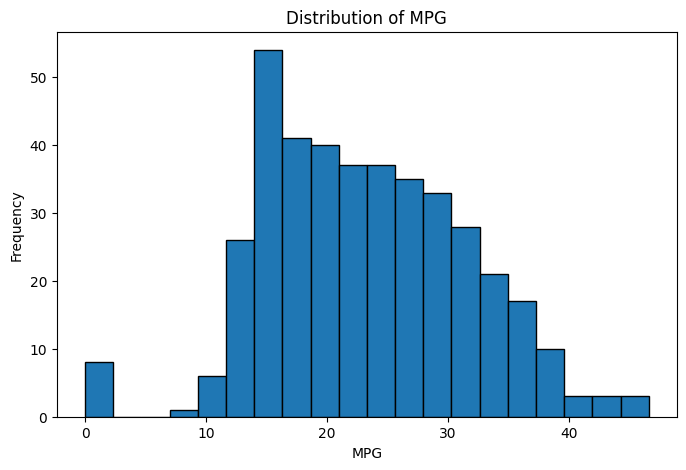

In [55]:
# Convert MPG to numeric
df_cars['MPG'] = pd.to_numeric(df_cars['MPG'], errors='coerce')

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(df_cars['MPG'].dropna(), bins=20, edgecolor='black')
plt.title('Distribution of MPG')
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.show()

The distribution is approximately normal, so we impute `MPG` missing values with the mean.

In [56]:
# Calculate mean
mpg_mean = df_cars['MPG'].mean()
print(f"Mean MPG: {mpg_mean:.2f}")

# Impute missing values
df_cars['MPG'] = df_cars['MPG'].fillna(mpg_mean)

# Verify
print("Missing Values in MPG:", df_cars['MPG'].isnull().sum())

Mean MPG: 23.10
Missing Values in MPG: 0


### Step 6: Use SimpleImputer

We apply `SimpleImputer` to all numerical columns for systematic imputation.

In [57]:
# Select numerical columns
numerical_cols = df_cars.select_dtypes(include=['float64', 'int64']).columns

# Initialize imputer
imputer = SimpleImputer(strategy='mean')

# Fit and transform
df_cars[numerical_cols] = imputer.fit_transform(df_cars[numerical_cols])

# Verify
print("Missing Values after Imputation:")
print(df_cars[numerical_cols].isnull().sum())

Missing Values after Imputation:
MPG    0
dtype: int64


## Outlier Detection - Sales Minimized Dataset

Outliers are data points that significantly deviate from the norm, often due to errors or exceptional events. In this section, we analyze the `salesMinimized.csv` dataset, which tracks daily sales of hobby items at a store (`CA_1`) over 70 days. We aim to identify items with unusually high sales using:

1. **Visualization**: Box plots and scatter plots to visually detect outliers.
2. **Z-Score**: Identify items with total sales beyond ±3 standard deviations.
3. **Inter-Quartile Range (IQR)**: Detect items with sales outside Q1 - 1.5*IQR or Q3 + 1.5*IQR.

### Step 1: Load the Dataset

We load the dataset and inspect its structure.

In [58]:
# Load the sales minimized dataset
df_sales = pd.read_csv('./CSVs/salesMinimized.csv')

# Display the first few rows
print("First few rows of the dataset:")
print(tabulate(df_sales.head(), headers='keys', tablefmt='grid'))

First few rows of the dataset:
+----+--------------+-------------------------------+---------------+-----------+----------+------------+------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|    |   Unnamed: 0 | id                            | item_id       | dept_id   | cat_id   | store_id   | state_id   |   d_1 |   d_2 |   d_3 |   d_4 |   d_5 |   d_6 |   d_7 |   d_8 |   d_9 |   d_10 |   d_11 |   d_12 |   d_13 |   

### Step 2: Compute Total Sales

The dataset contains daily sales (`d_1` to `d_70`) for each item, which are sparse (many zeros). To detect outliers, we compute `Total_Sales` per item by summing sales across all days. High `Total_Sales` values may indicate outlier items (e.g., due to promotions or errors).

In [59]:
# Sum sales across days (d_1 to d_70)
sales_cols = [col for col in df_sales.columns if col.startswith('d_')]
df_sales['Total_Sales'] = df_sales[sales_cols].sum(axis=1)

# Display the dataset with total sales
console = Console()
table = Table(title="Dataset with Total_Sales column", show_header=True, header_style="bold magenta")
table.add_column("Index", style="dim", width=12)
table.add_column("Item ID", justify="left")
table.add_column("Total Sales", justify="right")

for idx, row in df_sales[['item_id', 'Total_Sales']].head().iterrows():
    table.add_row(str(idx), str(row['item_id']), str(row['Total_Sales']))

console.print(table)

       Dataset with Total_Sales column        
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Index        ┃ Item ID       ┃ Total Sales ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ 0            │ HOBBIES_1_001 │           0 │
│ 1            │ HOBBIES_1_002 │           0 │
│ 2            │ HOBBIES_1_003 │           0 │
│ 3            │ HOBBIES_1_004 │          19 │
│ 4            │ HOBBIES_1_005 │           0 │
└──────────────┴───────────────┴─────────────┘

### Step 3: Box Plot Visualization

A box plot visualizes the distribution of `Total_Sales`, showing quartiles and potential outliers (points beyond the whiskers). Outliers are items with exceptionally high sales.

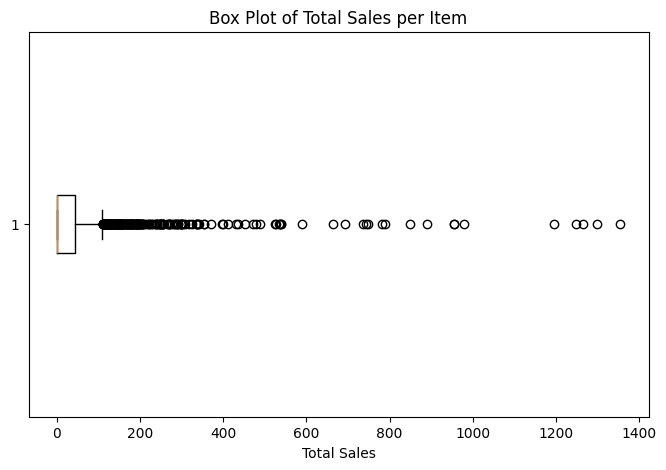

In [60]:
# Box plot for Total_Sales
plt.figure(figsize=(8, 5))
plt.boxplot(df_sales['Total_Sales'].dropna(), vert=False)
plt.title('Box Plot of Total Sales per Item')
plt.xlabel('Total Sales')
plt.show()

### Step 4: Scatter Plot Visualization

A scatter plot of `Total_Sales` against item indices helps identify items with extreme sales values, providing context for outliers in relation to other items.

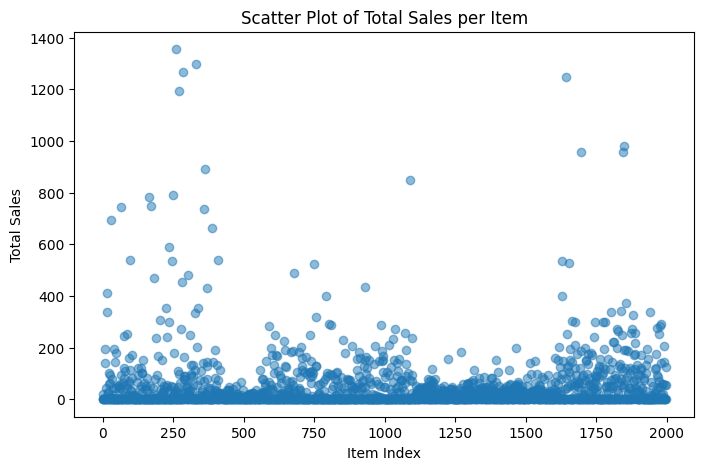

In [61]:
# Scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(range(len(df_sales)), df_sales['Total_Sales'], alpha=0.5)
plt.title('Scatter Plot of Total Sales per Item')
plt.xlabel('Item Index')
plt.ylabel('Total Sales')
plt.show()

### Step 5: Z-Score Method

The Z-Score measures how many standard deviations a data point is from the mean. We consider items with |Z-Score| > 3 for `Total_Sales` as outliers, indicating unusually high sales.

In [62]:
# Calculate Z-Scores
df_sales['Total_Sales_ZScore'] = (df_sales['Total_Sales'] - df_sales['Total_Sales'].mean()) / df_sales['Total_Sales'].std()

# Identify outliers
outliers_zscore = df_sales[abs(df_sales['Total_Sales_ZScore']) > 3]
print("\nOutliers based on Z-Score:")
print(tabulate(outliers_zscore[['item_id', 'Total_Sales', 'Total_Sales_ZScore']], headers='keys', tablefmt='grid'))


Outliers based on Z-Score:
+------+-----------------+---------------+----------------------+
|      | item_id         |   Total_Sales |   Total_Sales_ZScore |
+======+=================+===============+======================+
|   15 | HOBBIES_1_016   |           411 |              3.26415 |
+------+-----------------+---------------+----------------------+
|   31 | HOBBIES_1_032   |           694 |              5.78512 |
+------+-----------------+---------------+----------------------+
|   65 | HOBBIES_1_067   |           743 |              6.22161 |
+------+-----------------+---------------+----------------------+
|   98 | HOBBIES_1_103   |           540 |              4.41328 |
+------+-----------------+---------------+----------------------+
|  164 | HOBBIES_1_169   |           781 |              6.56012 |
+------+-----------------+---------------+----------------------+
|  173 | HOBBIES_1_178   |           749 |              6.27506 |
+------+-----------------+---------------+------

### Step 6: IQR Method

The IQR method identifies outliers as items with `Total_Sales` below Q1 - 1.5*IQR or above Q3 + 1.5*IQR. This is effective for sparse data, where many items have zero or low sales.

In [63]:
# Calculate IQR
Q1 = df_sales['Total_Sales'].quantile(0.25)
Q3 = df_sales['Total_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_iqr = df_sales[(df_sales['Total_Sales'] < lower_bound) | (df_sales['Total_Sales'] > upper_bound)]
print("\nOutliers based on IQR:")
print(tabulate(outliers_iqr[['item_id', 'Total_Sales']], headers='keys', tablefmt='grid'))

# Remove outliers
df_sales_clean = df_sales[(df_sales['Total_Sales'] >= lower_bound) & (df_sales['Total_Sales'] <= upper_bound)]
print(f"\nShape after removing IQR outliers: {df_sales_clean.shape}")


Outliers based on IQR:
+------+-----------------+---------------+
|      | item_id         |   Total_Sales |
+======+=================+===============+
|    7 | HOBBIES_1_008   |           193 |
+------+-----------------+---------------+
|    8 | HOBBIES_1_009   |           141 |
+------+-----------------+---------------+
|   14 | HOBBIES_1_015   |           339 |
+------+-----------------+---------------+
|   15 | HOBBIES_1_016   |           411 |
+------+-----------------+---------------+
|   31 | HOBBIES_1_032   |           694 |
+------+-----------------+---------------+
|   42 | HOBBIES_1_043   |           194 |
+------+-----------------+---------------+
|   43 | HOBBIES_1_044   |           145 |
+------+-----------------+---------------+
|   46 | HOBBIES_1_047   |           179 |
+------+-----------------+---------------+
|   65 | HOBBIES_1_067   |           743 |
+------+-----------------+---------------+
|   75 | HOBBIES_1_078   |           121 |
+------+-----------------+----